# Using the UNIONS/CFIS ShapePipe weak-lensing catalogues

Tutorial for v1.0 (April 2022)

See also `README_SP_v1.0.txt`.

Author: Martin Kilbinger <martin.kilbinger@cea.fr>

The ShapePipe core team:
- Axel Guinot
- Sam Farrens
- Tobias Liaudat

ShapePipe is publicly available at https://github.com/cosmostat/shapepipe .

See https://arxiv.org/abs/2204.04798 for details of the analysis of a previous version of the ShapePipe catalogue. 

In [3]:
# Required python libraries and settings

import matplotlib
%matplotlib inline

import numpy as np
from astropy.io import fits
import matplotlib as mpl
import matplotlib.pylab as plt

plt.rcParams['font.size'] = 20

In [4]:
# Optional: To compute the example shear-shear correlation functions
import treecorr

In [5]:
# Catalogue name base
cat_base = 'unions_shapepipe'
year = 2022

# Version
version = 'v1.0'

## 1. Base calibrated weak-lensing catalogue
This catalogue should be used *as is*.

The shear estimates are calibrated for the entire catalogue. If you intend to apply selections or cuts that depend on galaxy properties, in particular to magnitude, the calibration should be redone. In that case we recommend to use the extended catalogue, see Section 2 below.

So, if you want to use this (calibrated) shear catalogue:
- do not match to another sample (e.g. spectroscopic galaxies, or LensFit catalogue)
- do not apply cuts (e.g. in magnitude)

It is fine to apply selections that do not correlate with galaxy properties, such as select spatial sub-areas, regions around clusters, etc.

### Open FITS file

In [6]:
cat_name = f'{cat_base}_{year}_{version}.fits'
print(f'Opening base catalogue {cat_name}...')
hdu_list = fits.open(cat_name)
data = hdu_list[1].data

Opening base catalogue unions_shapepipe_2022_v1.0.fits...


### Print file content information

In [7]:
# Column names
data.dtype.names

('RA', 'Dec', 'e1', 'e2', 'w', 'mag', 'patch')

In [8]:
# Number of objects
len(data)

97239250

In [9]:
# Print headers
hdu_list[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
AUTHOR  = 'mkilbing'           / Who ran the software                           
SOFTNAME= 'sp_validation'      / Name of the software                           
SOFTVERS= '0.3.3   '           / Version of the software                        
DATE    = '2022-04-19_15-50-42' / When it was started                           
R       = '<R>     '           / Mean full response <R_shear> + <R_select>      
R_11    =   0.6891199907965454 / Full response matrix comp 1 1                  
R_12    = 0.000144995449973587 / Full response matrix comp 1 2                  
R_21    = 7.83877734394397E-05 / Full response matrix comp 2 1                  
R_22    =   0.68905980432155

In [10]:
hdu_list[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   50 / length of dimension 1                          
NAXIS2  =             97239250 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    7 / number of table fields                         
TTYPE1  = 'RA      '                                                            
TFORM1  = 'D       '                                                            
TUNIT1  = 'deg     '                                                            
TTYPE2  = 'Dec     '                                                            
TFORM2  = 'D       '        

### Example 1: Plot magnitude distribution

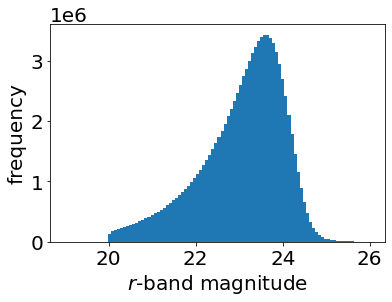

In [40]:
plt.hist(data['mag'], bins=100, range=(19, 26))
plt.xlabel('$r$-band magnitude')
_ = plt.ylabel('frequency')

### Example 2: Compute shear-shear correlation function

In [37]:
# Create TreeCorr configuration

# Get coordinate units from FITS file
coord_unit = hdu_list[1].header['TUNIT1']
if coord_unit != hdu_list[1].header['TUNIT2']:
    raise ValueError('Units for RA and Dec should be equal')

# Set output unit of angular separation
sep_unit = 'arcmin'

TreeCorrConfig = {
        'ra_units': coord_unit,
        'dec_units': coord_unit,
        'max_sep': '200',
        'min_sep': '1',
        'sep_units': sep_unit,
        'nbins': 20
    }

In [38]:
# Create TreeCorr catalogue
cat_gal = treecorr.Catalog(
    ra=data['RA'],
    dec=data['Dec'],
    g1=data['e1'],
    g2=data['e2'],
    w=data['w'],
    ra_units=coord_unit,
    dec_units=coord_unit
)

In [13]:
# Create correlation object
gg = treecorr.GGCorrelation(TreeCorrConfig)

In [14]:
# Process correlation. This can take a few minutes.
gg.process(cat_gal, cat_gal)

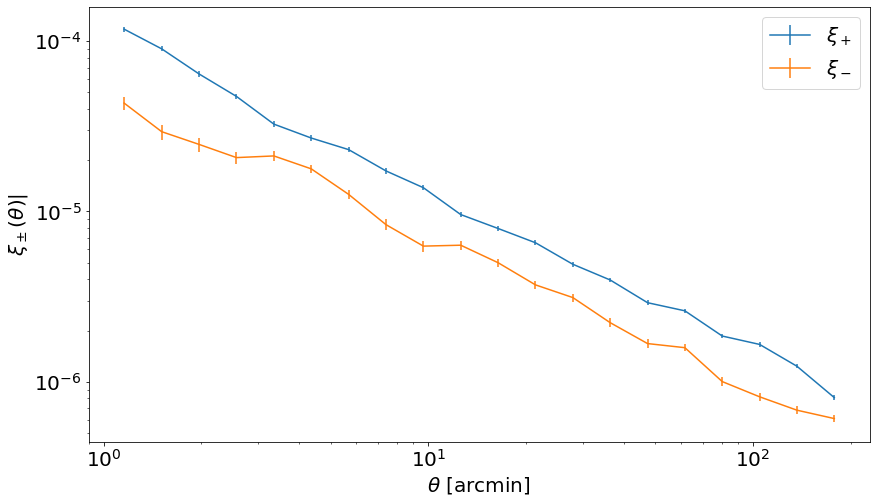

In [15]:
# Plot components of the correlation functions
plt.figure(figsize=(14,8))

plt.errorbar(gg.meanr, gg.xip, yerr=np.sqrt(gg.varxip), label=r'$\xi_+$')
plt.errorbar(gg.meanr, gg.xim, yerr=np.sqrt(gg.varxim), label=r'$\xi_-$')
plt.loglog()

plt.legend()
plt.xlabel(rf'$\theta$ [{sep_unit}]')
_ = plt.ylabel(r'$\xi_\pm(\theta)$')

## 2. Extended weak-lensing catalogue

This catalogue needs to be *calibrated before use*.
It contains the relevant information to calibrate the catalogue, with the method of *metacalibration* (https://arxiv.org/abs/1702.02600).

Cuts can be applied to the catalogue before calibration.

### Open FITS file

In [16]:
cat_ext_name = f'{cat_base}_extended_{year}_{version}.fits'
print(f'Openging catalogue {cat_ext_name}...')
hdu_list_ext = fits.open(cat_ext_name)
data_ext = hdu_list_ext[1].data 

Openging catalogue unions_shapepipe_extended_2022_v1.0.fits...


### Print file content information

In [17]:
# Print column names
data_ext.dtype.names

('RA',
 'Dec',
 'e1',
 'e2',
 'w',
 'mag',
 'snr',
 'e1_uncal',
 'e2_uncal',
 'R_g11',
 'R_g22',
 'R_g12',
 'R_g21',
 'e1_PSF',
 'e2_PSF',
 'fwhm_PSF',
 'mask_extern',
 'patch')

In [18]:
# Number of objects
len(data_ext)

97239250

### Shear calibration

The calibration for ShapePipe depends on the properties of the galaxy sample. It should be
carried out after selecting a (sub-)sample of galaxies.

In [26]:
# First step: Apply cuts, select (sub-)sample of galaxies.
# The following dummy example selects the entire sample.
mask = np.full(len(data_ext), True)

# Other examples:
## Select objects in LensFit umasked regions
# mask = data_ext['mask_extern'] == 0

## Select objects in patch P3
# mask = data_ext['patch'] == 3

## r-band magnitude cut
# mask = data_ext['mag'] < 23.5

n_kept = len(np.where(mask == True)[0])
n_all = len(data_ext)
print(
    f'Keeping {n_kept}/{n_all} = '
    + f'{n_kept / n_all * 100:.1f}% objects'
)

data_ext_sub = data_ext[mask]

Keeping 97239250/97239250 = 100.0% objects


In [27]:
# Second step: Carry out calibration, as follows.

#### Compute additive bias

In [28]:
# For a survey as large as UNIONS/CFIS, the assumption that the mean shear over
# the observed area vanishes, is a very good approximation.
# Then, the additive bias is the weighted mean of the uncalibrated ellipticities.

# This value corresponding to the entire sample is also given in the
# catalogue FITS header.

c = np.empty(shape=(2))
for comp in (0, 1):
    c[comp] = np.average(
        data_ext_sub[f'e{comp+1}_uncal'],
        weights=data_ext_sub['w']
    )

In [29]:
print('Additive bias')
for comp in (0, 1):
    print(f'c_{comp+1} = {c[comp]:.3g}')

Additive bias
c_1 = -0.000186
c_2 = 0.000152


#### Compute multiplicative bias

In the metacalibration scheme the multiplicative bias is a 2x2 matrix $R$.
It is the sum of the shear response matrix $R_g$ and the selection response matrix $R_\textrm{s}$,
$$R = R_g + R_\textrm{s} .$$
These matrices corresponding to the entire sample are also given in the catalogue FITS header.

##### Shear response matrix $R_g$

In [30]:
# The shear response matrix for each individual galaxy is part of the extended catalogue.
# The corresponding ensemble matrix for a (sub-)sample needs to be computed
# after selecting the (sub-)sample in the first step above.

R_g = np.empty(shape=(2, 2))

for idx in (0, 1):
    for jdx in (0, 1):
        R_g[idx, jdx] = np.mean(data_ext_sub[f'R_g{idx+1}{jdx+1}'])

In [31]:
print('Shear response matrix R_g =')
print(np.matrix(R_g))

Shear response matrix R_g =
[[6.84763191e-01 1.41395450e-04]
 [1.39087773e-04 6.85960504e-01]]


##### Selection matrix $R_\textrm{s}$

The selection matrix was pre-computed for the entire galaxy sample; it is not
possible do obtain $R_\textrm{s}$ for individual galaxies. Therefore, in this
version of the ShapePipe catalogue we use the global selection matrix also for
sub-samples of galaxies. This will be improved in future versions.

Since $|R_\textrm{s}| < |R_g|$, the resulting error is small.

In [32]:
R_s = np.empty(shape=(2, 2))
for idx in (0, 1):
    for jdx in (0, 1):
        R_s[idx][jdx] = hdu_list_ext[0].header[f'R_S{idx+1}{jdx+1}']

In [33]:
print('Selection response matrix R_s =')
print(np.matrix(R_s))

Selection response matrix R_s =
[[ 4.3568e-03  3.6000e-06]
 [-6.0700e-05  3.0993e-03]]


##### Total response matrix $R = R_g + R_\textrm{s}$

In [34]:
R = R_g + R_s

print('Total response matrix R =')
print(np.matrix(R))

Total response matrix R =
[[6.89119991e-01 1.44995450e-04]
 [7.83877734e-05 6.89059804e-01]]


#### Apply calibration to raw shear values and obtain calibrated shear estimates

The relation between observed shear $\gamma^\textrm{obs}$ and true shear $\gamma$ is given by the matrix equation
$$\gamma^\textrm{obs} = R \gamma + c .$$
To account for the two biases we subtract the additive term, and multiply with the inverse of the total response matrix.

In [35]:
e_uncal_minus_c = np.array([
    data_ext['e1_uncal'] - c[0],
    data_ext['e2_uncal'] - c[1]
])
Rm1 = np.linalg.inv(R)
e_cal = Rm1.dot(e_uncal_minus_c)

In [36]:
# Cross-check (*only* valid if no cut has been applied to galaxysample):
# Compare first few calibrated shears from base catalogue to
# the ones from the extended catalogue calibrated "by hand"

print(e_cal[:,0:3])

print(data['e1'][0:3], data['e2'][0:3])

[[ 0.07302936 -0.61328627  0.20705113]
 [-0.06351253  0.29880159  0.64937902]]
[ 0.07302936 -0.61328627  0.20705113] [-0.06351253  0.29880159  0.64937902]
